In [44]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [45]:
df = pd.read_csv('Trojan_Detection.csv')

# Drop constant columns
constant_cols = df.columns[df.nunique() <= 1]
df.drop(columns=constant_cols, inplace=True)

# Handle missing values
for column in df.columns:
    if df[column].isnull().sum() > 0:
        if df[column].dtype == 'object':
            df[column] = df[column].fillna(df[column].mode()[0])
        else:
            df[column] = df[column].fillna(df[column].mean())

# Encode categorical features
label_encoders = {}
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

In [46]:
# Remove duplicated columns
df = df.loc[:, ~df.T.duplicated()]


In [47]:
# Drop irrelevant columns
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

In [48]:
# Prepare X and y
X = df.drop(columns=['Class'])  # Feature set
y = df['Class']                 # Target


In [49]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
# Select top 20 features
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_scaled, y)

In [52]:
# Get selected feature names
selected_columns = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_columns)
# Print selected features and their ANOVA F-scores
feature_scores = selector.scores_[selector.get_support()]
features_with_scores = sorted(zip(selected_columns, feature_scores), key=lambda x: x[1], reverse=True)

print("\n=== Top 20 Selected Features and Their Importance Scores ===")
for feature, score in features_with_scores:
    print(f"{feature}: {score:.4f}")


=== Top 20 Selected Features and Their Importance Scores ===
 Timestamp: 568605.2614
Fwd IAT Total: 486.5852
 Fwd IAT Max: 476.3554
 Idle Max: 413.5774
Flow ID: 395.2779
 Bwd Packets/s: 351.5106
Idle Mean: 343.5096
 Active Min: 342.9889
Active Mean: 339.2192
 Destination IP: 301.3778
 Active Max: 281.5723
 Idle Min: 278.6465
 Min Packet Length: 262.2809
 Flow Duration: 254.2023
 Fwd Packet Length Max: 228.4010
 Idle Std: 224.4488
 Fwd IAT Std: 220.5869
 Fwd Packet Length Std: 214.5183
 Flow IAT Max: 194.7046
 Down/Up Ratio: 187.4878


In [35]:
# Add the target column back
X_selected_df['Class'] = y.values

In [36]:
# Save the cleaned dataset
X_selected_df.to_csv('trojan_cleaned_selected.csv', index=False)
print("Data cleaning and feature selection completed. Saved to 'trojan_cleaned_selected.csv'.")

Data cleaning and feature selection completed. Saved to 'trojan_cleaned_selected.csv'.


In [37]:
# Reload the prepared dataset
df = pd.read_csv('trojan_cleaned_selected.csv')

In [38]:
# Prepare features and labels
X = df.drop(columns=['Class'])
y = df['Class']


In [39]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [40]:
# Train the SVM model
model = SVC(kernel='rbf', C=1.0, gamma='scale')
model.fit(X_train, y_train)
print("Model training completed.")

Model training completed.



=== SVM Results ===
Accuracy: 0.974532819983097

Confusion Matrix:
 [[26008    32]
 [ 1324 25881]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     26040
           1       1.00      0.95      0.97     27205

    accuracy                           0.97     53245
   macro avg       0.98      0.98      0.97     53245
weighted avg       0.98      0.97      0.97     53245



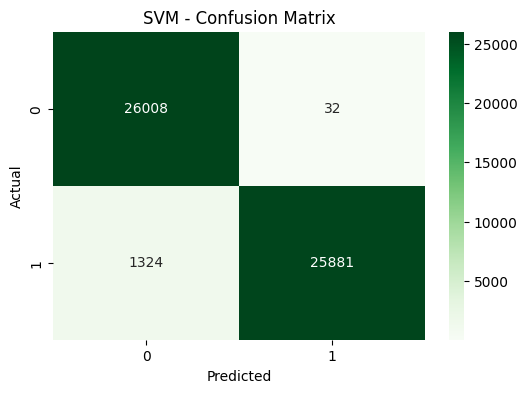

In [41]:
# Evaluate the model
y_pred = model.predict(X_test)

print("\n=== SVM Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix SVM
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

=== Logistic Regression Results ===
Accuracy: 0.9767114283031271

Confusion Matrix:
 [[26038     2]
 [ 1238 25967]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     26040
           1       1.00      0.95      0.98     27205

    accuracy                           0.98     53245
   macro avg       0.98      0.98      0.98     53245
weighted avg       0.98      0.98      0.98     53245



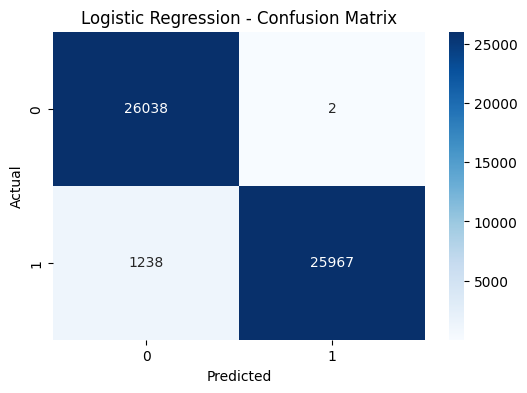

In [42]:
from sklearn.linear_model import LogisticRegression

# ====== 1. Logistic Regression ======
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

# Confusion Matrix Logistic Regression
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()